In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import os

In [6]:
data_dir = 'strive_mask_dataset/'

# TODO: Define transforms for the training data and testing data
train_transform = transforms.Compose(
            [transforms.Resize([224, 224]),
                #transforms.RandomCrop(224),
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])


test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])



# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder('strive_mask_dataset/train/', transform=train_transform)
test_data  = datasets.ImageFolder('strive_mask_dataset/test/', transform=test_transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
train_data.classes

['design_mask',
 'design_mask_bad',
 'medical_mask',
 'medical_mask_bad',
 'no_mask']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

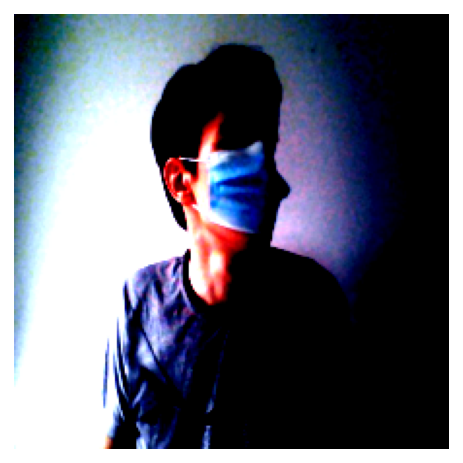

In [10]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


# Run this to test your data loaders
images, labels = next(iter(trainloader))
imshow(images[0], normalize=True)

In [11]:
class mask_net(nn.Module):

    def __init__(self):
        super().__init__()
        self.model_ft = models.resnet18(pretrained=True)
        #for param in self.model_ft.features.parameters():
         #   param.requires_grad = False
        self.num_ftrs = self.model_ft.fc.in_features
        layers = list(self.model_ft.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        self.classifier = nn.Linear(self.num_ftrs, 5)

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        out = self.classifier(representations)

        return out


model = mask_net()
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
model

mask_net(
  (model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [13]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        
        optimizer.zero_grad()
        
        output = model.forward(inputs)  # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
           
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for inputs, labels in testloader:
                    
                    output = model.forward(inputs)
                    batch_loss = criterion(output, labels)
                    test_loss += batch_loss.item()
                    
                    #calculate accuracy
                    ps = torch.exp(output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                   
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.."
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test Accuracy: {accuracy/len(testloader):.3f}..")
            running_loss = 0
            model.train()
    torch.save(model.state_dict(), 'checkpoint.pth')

Epoch 1/10.. Train loss: 1.739..Test loss: 1.491.. Test Accuracy: 0.407..
Epoch 1/10.. Train loss: 1.441..Test loss: 1.324.. Test Accuracy: 0.560..
Epoch 1/10.. Train loss: 1.284..Test loss: 1.247.. Test Accuracy: 0.535..
Epoch 1/10.. Train loss: 1.102..Test loss: 1.191.. Test Accuracy: 0.585..
Epoch 1/10.. Train loss: 0.981..Test loss: 1.172.. Test Accuracy: 0.559..
Epoch 2/10.. Train loss: 0.887..Test loss: 1.145.. Test Accuracy: 0.586..
Epoch 2/10.. Train loss: 0.832..Test loss: 1.171.. Test Accuracy: 0.554..
Epoch 2/10.. Train loss: 0.811..Test loss: 1.128.. Test Accuracy: 0.568..
Epoch 2/10.. Train loss: 0.816..Test loss: 1.175.. Test Accuracy: 0.556..
Epoch 2/10.. Train loss: 0.787..Test loss: 1.133.. Test Accuracy: 0.585..
Epoch 3/10.. Train loss: 0.741..Test loss: 1.153.. Test Accuracy: 0.570..
Epoch 3/10.. Train loss: 0.712..Test loss: 1.093.. Test Accuracy: 0.584..
Epoch 3/10.. Train loss: 0.660..Test loss: 1.099.. Test Accuracy: 0.590..
Epoch 3/10.. Train loss: 0.660..Test l

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9f1e7bdb-154a-4549-a646-7775bf1dc7a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>